In [21]:
import sys
import os 

os.environ["CONFIG_PATHS"] = "../../configs/self_play.yaml"
os.environ["CONFIG_OVERRIDES"] = 'game.moves_directory="../../data/moves_10"'
sys.path.append("../../src")

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import random
import glob 

from analysis import load_events, filter_events
from display import Display
import player_pov_helpers
from training.load_games import load_games_new

In [22]:
directory = "../../data/2024-12-22_19-00-03-arena-for-glochidate-vs-latest-dh/"

events_path = max(glob.glob(directory + "/logs_*.txt"))
print(events_path)
events = load_events(events_path)

../../data/2024-12-22_19-00-03-arena-for-glochidate-vs-latest-dh/logs_2024-12-22_19-30-09_058659.txt
Start time: 1734922869.784506


In [23]:
for event in events:
    if event.name == "loaded_model":
        print(event.params)

{'model_name': '001410000'}
{'model_name': '002190002'}


In [24]:
game_result_events = filter_events(events, "game_result")
if "scores" in game_result_events[0].params:
    game_results = [event.params["scores"] for event in game_result_events]
else:
    game_results = [event.params for event in game_result_events]

# I didn't zfill the player names, so we need to do that now
# for sorting to work.
# for game_result in game_results:
#     for result_line in game_result:
#         result_line[0] = result_line[0][1:].zfill(6)

players = set()
for game_result in game_results:
    for player, _ in game_result:
        players.add(player)

# players = sorted(list(players), key=lambda x: int(x))
players = sorted(list(players))

print(players)
print("Number of games:", len(game_results))

['dh_0.3', 'dh_1.0', 'gloch_0.3', 'gloch_1.0']
Number of games: 3072


In [25]:
gamedata_paths = glob.glob(directory + "/games/*.npz")
gamedata = load_games_new(gamedata_paths)

event | 1734924619.6661918 | bad_game_file | {"path": "../../data/2024-12-22_19-00-03-arena-for-glochidate-vs-latest-dh//games/1734924243068_21.npz"}
event | 1734924620.629954 | bad_game_file | {"path": "../../data/2024-12-22_19-00-03-arena-for-glochidate-vs-latest-dh//games/1734923628767_23.npz"}
event | 1734924621.563211 | bad_game_file | {"path": "../../data/2024-12-22_19-00-03-arena-for-glochidate-vs-latest-dh//games/1734924288416_22.npz"}


In [26]:
terminal_board_indices = []
terminal_boards = []
for i in range(len(gamedata["game_ids"]) - 1):
    if gamedata["game_ids"][i] != gamedata["game_ids"][i + 1]:
        terminal_board_indices.append(i)
        terminal_boards.append(gamedata["boards"][i])

boards_seen = set()
games_with_unique_terminal_boards = []

for index, board in zip(terminal_board_indices, terminal_boards):
    if board.tobytes() not in boards_seen:
        games_with_unique_terminal_boards.append(gamedata["game_ids"][index])
        boards_seen.add(board.tobytes())
        
print("Number of terminal boards:", len(terminal_boards))
print("Number of unique terminal boards:", len(boards_seen))
print("Percent of non-duplicate games:", len(games_with_unique_terminal_boards) / len(terminal_boards))

Number of terminal boards: 3065
Number of unique terminal boards: 2773
Percent of non-duplicate games: 0.9047308319738988


In [27]:
# Do a naive calculation of average performance per game per player.
player_total_scores = {player: 0 for player in players}
player_total_games = {player: 0 for player in players}

for game_result in game_results:
    for player, result in game_result:
        player_total_scores[player] += result
        player_total_games[player] += 1

player_average_scores = {player: player_total_scores[player] / player_total_games[player] for player in players}
player_average_scores

{'dh_0.3': 0.27853732638888934,
 'dh_1.0': 0.23502604166666685,
 'gloch_0.3': 0.29519314236111166,
 'gloch_1.0': 0.1912434895833333}

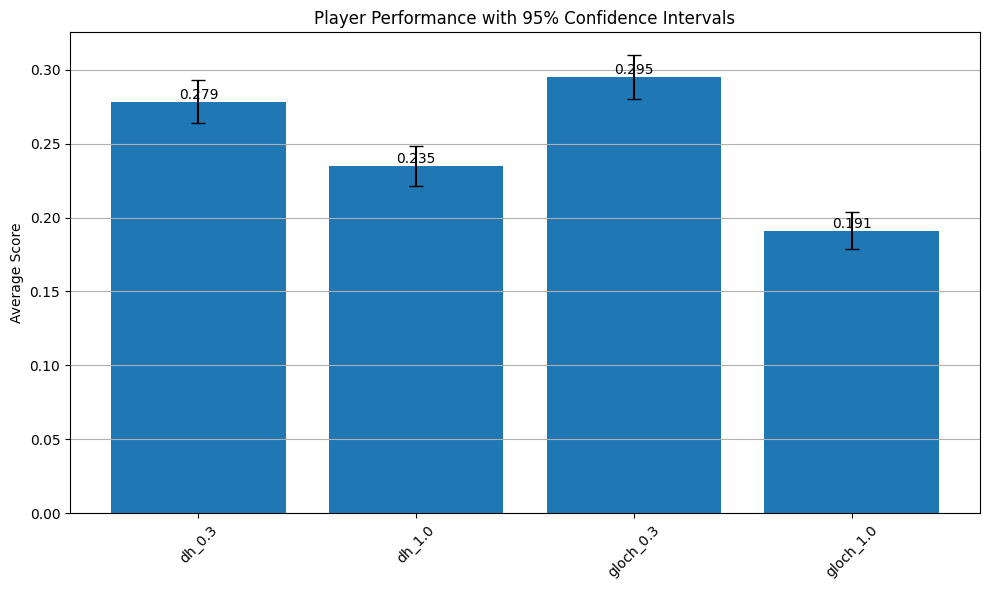

In [28]:
player_results = {}

filtered_game_results = game_results

# filtered_game_results = [
#     game_result_event.params["scores"] for game_result_event in game_result_events
#     if game_result_event.params["game_id"] in games_with_unique_terminal_boards
# ]

for game_result in filtered_game_results:
    for player, result in game_result:
        player_results[player] = player_results.get(player, []) + [result]

player_average = {}
for player in player_results:
    player_average[player] = np.mean(player_results[player])

player_error_range = {}
for player in player_results:
    std = np.std(player_results[player]) / np.sqrt(len(player_results[player]))
    player_error_range[player] = 1.96 * std

plt.figure(figsize=(10, 6))

sorted_players = sorted(player_average.items(), key=lambda x: x[0])
players = [p[0] for p in sorted_players]
averages = [player_average[p] for p in players]
errors = [player_error_range[p] for p in players]

bars = plt.bar(players, averages, yerr=errors, capsize=5)

# Add value labels above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom')

plt.title("Player Performance with 95% Confidence Intervals")
plt.ylabel("Average Score")
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

In [ ]:
elos = [{player: 1000 for player in players}]

elo_K = 0.5
elo_base = 400.0

for _ in range(len(game_results) * 10):
    game_result = random.choice(game_results)

    latest_elo = elos[-1].copy()

    game_players = [player_name for player_name, _ in game_result]
    Q_player = [10 ** (latest_elo[player] / elo_base) for player in game_players]
    Q_total = sum(Q_player)
    E_player = [Q / Q_total for Q in Q_player]

    for i, (player, result) in enumerate(game_result):
        latest_elo[player] += elo_K * (result - E_player[i])

    elos.append(latest_elo)

# Extract player names from the first dictionary in elos
player_names = elos[0].keys()

# Prepare data for plotting
elo_history = {player: [] for player in player_names}

# Populate elo_history with ELO ratings over time
for elo_snapshot in elos:
    for player in player_names:
        elo_history[player].append(elo_snapshot[player])

# Plot ELO ratings for each player
plt.figure(figsize=(10, 6))
for player, history in elo_history.items():
    plt.plot(history, label=player)

plt.title("ELO Rating Convergence")
plt.xlabel("Game Number")
plt.ylabel("ELO Rating")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

final_elos = elos[-1]

In [ ]:
plt.figure(figsize=(10, 6))

filtered_players = [player for player in players]

elos_y = [final_elos[player] for player in filtered_players]
plt.bar(filtered_players, elos_y)

plt.title("Final ELO Ratings by Player ID")
plt.xlabel("Player ID")
plt.xticks(rotation=90)
plt.ylabel("ELO Rating")
plt.grid(True)
plt.ylim(bottom=min(elos_y) - 10, top=max(elos_y) + 10)  # Set y-axis to start at 900
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))

elos_x = [player for player in players]
elos_y = [final_elos[player] for player in players]
plt.bar(elos_x, elos_y, marker='o')
plt.legend()

plt.title("Final ELO Ratings by Player ID")
plt.xlabel("Player ID")
plt.ylabel("ELO Rating")
plt.grid(True)
plt.gca().get_xaxis().get_major_formatter().set_scientific(False)
plt.xlim(left=0)  # Set x-axis to start at 0
plt.tight_layout()
plt.show()

In [ ]:
terminal_board_hashes = [hash(board.tobytes()) for board in terminal_boards]
print(len(terminal_board_hashes))

In [ ]:
from collections import Counter

# Count frequency of each hash
hash_counts = Counter(terminal_board_hashes)

# For each frequency k, multiply by k to get total boards
total_boards_by_freq = {k: k*v for k,v in Counter(hash_counts.values()).items()}

# Sort by frequency for consistent visualization
labels = sorted(total_boards_by_freq.keys())
sizes = [total_boards_by_freq[k] for k in labels]

# Convert to percentages
total = sum(sizes)
sizes_pct = [s/total * 100 for s in sizes]

# Create labels showing both count and percentage
labels = [f'Appears {k} times ({s:.1f}%)' for k,s in zip(labels, sizes_pct)]

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', labeldistance=1.2, rotatelabels=True)
plt.title('Distribution of Terminal Board Frequencies\n(Counting Duplicates)')
plt.show()

In [ ]:
Display(terminal_boards[50]).show()

In [ ]:
terminal_board_indices[30]